In [468]:
import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'

import io
import PIL.Image, PIL.ImageDraw

import requests

import einops
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

# Notebook dependencies
from IPython.display import clear_output, Image

from original_utils import *

import importlib
import sys
importlib.reload(sys.modules['original_utils'])
from original_utils import *

device_id = 1
device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
print('device is {}'.format(device))

device is cuda:1


In [154]:
# Parameters

CHANNEL_N = 16
TARGET_PADDING = 16
BATCH_SIZE = 8
POOL_SIZE = 1024
CELL_FIRE_RATE = 0.5

TARGET_EMOJI = "🛩"

USE_PATTERN_POOL = True # set in "persistent" mode

# Load target image
target_img = load_emoji(TARGET_EMOJI)

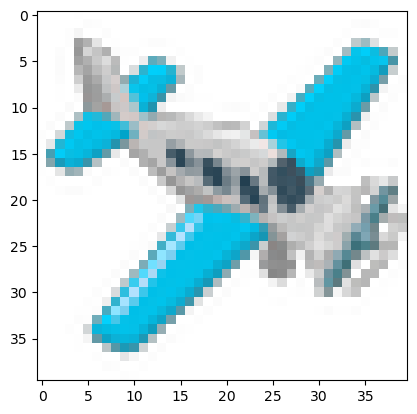

In [155]:
plt.imshow(target_img)
plt.show()

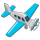

In [156]:
imshow(target_img)

In [461]:
# Define Model

class CAModel(nn.Module):
  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    conv1 = nn.Conv2d(in_channels=self.channel_n*3, out_channels=128, kernel_size=1)
    conv2 = nn.Conv2d(in_channels=128, out_channels=self.channel_n, kernel_size=1)
    
    # Apply "do-nothing" initial behavior
    # torch.nn.init.xavier_uniform_(conv1.weight) # default to how tensorflow initializes the weights
    torch.nn.init.zeros_(conv2.weight)
    torch.nn.init.zeros_(conv1.bias)
    torch.nn.init.zeros_(conv2.bias)

    self.dmodel = nn.Sequential(
        conv1,
        nn.ReLU(),
        conv2,
    )
    
  def perceive(self, x, angle=0.0):
    """Pytorch does convolutions differently. Reshape accordingly
      input is (batch, in_channels, H, W)
      kernel is (filter_height, filter_width, in_channels, channel_multiplier) in TF
      but should be (out_channels, in_channels / groups, H, W) in Torch"""
    identify = torch.as_tensor([0, 1, 0], dtype=torch.float32)
    identify = torch.outer(identify, identify)
    dx = torch.as_tensor(np.outer([1, 2, 1], [-1, 0, 1]) / 8.0, dtype=torch.float32) # Sobel filter
    dy = dx.T
    c, s = torch.cos(torch.tensor(angle)), torch.sin(torch.tensor(angle))
    stacked_filters = torch.stack((identify, c*dx-s*dy, s*dx+c*dy)).to(device)
    
    kernel = stacked_filters.tile((self.channel_n, 1, 1))
    y = F.conv2d(x, kernel[:, None, :, :], padding='same', groups=self.channel_n)
    
    # kernel = torch.repeat_interleave(stacked_filters, self.channel_n, dim=0).view(self.channel_n*3, 1, 3, 3)
    # y = F.conv2d(x, kernel, padding='same', groups=self.channel_n)
    return y

  def forward(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    x = torch.permute(x, (0, 3, 1, 2)) # make it shape [batch_size, in_channels, H, W]
    pre_life_mask = get_living_mask(x)

    y = self.perceive(x, angle) # y should be on device
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = torch.rand(x[:, :1, :, :].shape, device=device, dtype=torch.float32) <= fire_rate
    x = x + dx * update_mask

    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    result = x * life_mask
    return torch.permute(result, (0, 2, 3, 1)) # send it back [batch_size, H, W, in_channels]

CAModel().dmodel

Sequential(
  (0): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
)

In [168]:
# Model from minimal nca implementation

# Implement the Neural Cellular Automata as a PyTorch module
class CA(nn.Module): 
  def __init__(self, state_dim=CHANNEL_N, hidden_dim=128):
    super(CA, self).__init__()
    
    print("\nREMINDER: Using Minimal NCA Model")
    
    self.state_dim = state_dim
    self.update = nn.Sequential(nn.Conv2d(state_dim, 3*state_dim, 3, padding=1, groups=state_dim, bias=False),  # perceive
                                nn.Conv2d(3*state_dim, hidden_dim, 1),  # process perceptual inputs
                                nn.ReLU(),                              # nonlinearity
                                nn.Conv2d(hidden_dim, state_dim, 1))    # output a residual update
    self.update[-1].weight.data *= 0  # initial residual updates should be close to zero
    
    # First conv layer will use fixed Sobel filters to perceive neighbors
    identity = np.outer([0, 1, 0], [0, 1, 0])       # identity filter
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0      # Sobel x filter
    kernel = np.stack([identity, dx, dx.T], axis=0) # stack (identity, dx, dy) filters
    kernel = np.tile(kernel, [state_dim,1,1])       # tile over channel dimension
    self.update[0].weight.data[...] = torch.Tensor(kernel)[:,None,:,:]
    self.update[0].weight.requires_grad = False
  
  # def forward(self, x, num_steps):
  def forward(self, x):
    
    # Make x have shape [B, C, H, W]    
    x = torch.permute(x, (0, 3, 1, 2)) 
    
    alive_mask = lambda alpha: nn.functional.max_pool2d(alpha, 3, stride=1, padding=1) > 0.1

    alive_mask_pre = alive_mask(alpha=x[:,3:4])
    update_mask = torch.rand(*x.shape, device=x.device) > 0.5  # run a state update 1/2 of time
    x = x + update_mask * self.update(x)                       # state update!
    x = x * alive_mask_pre * alive_mask(alpha=x[:,3:4])        # a cell is either living or dead
    
    # frames.append(x.clone()) 
    # output = frames[-1, ...] # get last frame of shape [B, C, H, W]
    
    # x has shape [B, C, H, W]
    return torch.permute(x, (0, 2, 3, 1)).contiguous() # return it with shape [B, H, W, C]
    
    # return torch.stack(frames) # axes: [N, B, C, H, W] where N is # of steps

CA().update


REMINDER: Using Minimal NCA Model


Sequential(
  (0): Conv2d(16, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
  (1): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU()
  (3): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
)

seed shape is torch.Size([72, 72, 16])


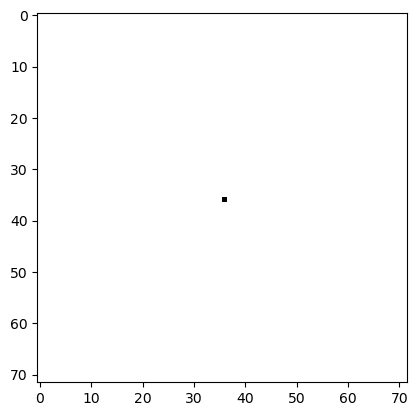

In [160]:
# Make training sample

p = TARGET_PADDING
target_img_tensor = torch.tensor(target_img)
pad_target = torch.nn.functional.pad(target_img_tensor, (0, 0, p, p, p, p))
h, w = pad_target.shape[:2]
seed = torch.zeros(h, w, CHANNEL_N, dtype=torch.float32)
seed[h//2, w//2, 3:] = 1.0
print(f'seed shape is {seed.shape}')

plt.imshow(seed[..., :4])
plt.show()

In [ ]:
test_load = load_ca_model(CAModel, "vanilla_ca")

In [252]:
print(torch.cuda.current_device())
seed.get_device()

0


-1

In [9]:
x0 = torch.repeat_interleave(seed[None, ...], BATCH_SIZE, dim=0)
print(seed.shape)
print(x0.shape)
print(x0.dtype, seed.dtype)
print(x0.min(), x0.max(), seed.min(), seed.max())

torch.Size([72, 72, 16])
torch.Size([8, 72, 72, 16])
torch.float32 torch.float32
tensor(0.) tensor(1.) tensor(0.) tensor(1.)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:55<00:00,  1.53it/s]


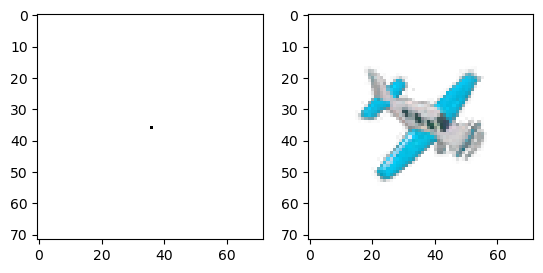

In [10]:
x = simulate_model(test_load, seed.unsqueeze(0), 85, device=device)

In [463]:
class SamplePool:
  def __init__(self, *, _parent=None, _parent_idx=None, **slots):
    self._parent = _parent
    self._parent_idx = _parent_idx
    self._slot_names = slots.keys()
    self._size = None
    for k, v in slots.items():
      if self._size is None:
        self._size = len(v)
      assert self._size == len(v)
      # setattr(self, k, np.asarray(v))
      setattr(self, k, v)        

  def sample(self, n):
    idx = np.random.choice(self._size, n, False)
    batch = {k: getattr(self, k)[idx] for k in self._slot_names}
    batch = SamplePool(**batch, _parent=self, _parent_idx=idx)
    return batch

  def commit(self):
    for k in self._slot_names:
      getattr(self._parent, k)[self._parent_idx] = getattr(self, k)

In [465]:
# Training Sequence

class Train:
  def __init__(self, ca_model, seed, target, lr=2e-3):
    """Initialize training object with model to train, seed and target
    
    :param ca_model: PyTorch model class object (instantiated)
    :param seed: PyTorch tensor of shape (H, W, C), initial seed to start training
    :param target: PyTorch tensor of shape (H, W, C), target image to learn
    """
    self.ca = ca_model
    self.seed = seed
    # Augment target tensor with batch dimension
    self.target = torch.repeat_interleave(target[None, ...], BATCH_SIZE, dim=0)
    self.lr = lr
    
    # Initialize optimizer with lr scheduler
    self.optim = torch.optim.Adam(self.ca.parameters(), lr=self.lr)
    # self.scheduler = torch.optim.lr_scheduler.StepLR(self.optim, step_size=2000, gamma=0.1)    
    self.scheduler = torch.optim.lr_scheduler.MultiStepLR(self.optim, milestones=[1500], gamma=0.25)
    
    # Use library MSELoss
    self.loss_f = nn.MSELoss()
    
    # Pool of training samples for "persistent" training mode
    # self.pool = SamplePool(x=np.repeat(self.seed.detach().cpu()[None, ...], POOL_SIZE, 0))
    self.pool = SamplePool(x=torch.repeat_interleave(self.seed[None, ...], POOL_SIZE, dim=0))

    # Log the training progress
    self.loss_log = []

  def train(self, n_steps=1001):
    """Train the model stored in `self.ca` for `n_steps` training steps

    :param n_steps: int, Number of training steps
    :return: list, loss history 
    """
    for i in range(n_steps):

      # Very similar to original TF implementation
      if USE_PATTERN_POOL:
        batch = self.pool.sample(BATCH_SIZE)
        x0 = batch.x.detach() # this computes grads by default, not sure why (hence the .detach())
        
        loss_rank = self._loss_f(x0, self.target).argsort(descending=True)
        x0 = x0[list(loss_rank.detach().cpu().numpy())]
        x0[:1] = seed # to prevent catastrophic forgetting
      else:
        x0 = torch.repeat_interleave(self.seed[None, ...], BATCH_SIZE, 0)
    
      # print(f"\n x0 type is {type(x0)} and shape is {x0.shape} and device is {x0.get_device()} and requires grad: {x0.requires_grad}")

      # Run through a single training step of the model
      x, loss = self._train_step(x0)
      self.loss_log.append(loss)
      # print(f'loss log is {self.loss_log}')
    
      # Update pool
      if USE_PATTERN_POOL:
        batch.x[:] = x
        batch.commit()

      # Printing
      if i % 100 == 0:
        clear_output()

        # Visualize batch
        visualize_batch(x0.detach().cpu(), x.detach().cpu(), i)
        
        # Plot loss
        plot_loss(self.loss_log)
        
        # Export model
        # TODO

      print('\r step: %d, log10(loss): %.3f'%(len(self.loss_log), np.log10(loss)), end='')

    return self.loss_log
    
  def _train_step(self, x):
    """Perform the update step some random number of times"""

    iter_n = np.random.randint(64, 97, dtype=np.int32)
    for _ in range(iter_n):
      # Forward pass of model
      x = self.ca(x)

    # Compute loss
    # loss = self.loss_f(to_rgba(x), self.target)
    loss = self._loss_f(x, self.target).mean()

    # Compute gradients
    loss.backward()
    
    # Apply L2 normalization to parameter gradients as per original paper
    for p in self.ca.parameters():
      if p.grad is not None:
        p.grad = p.grad / (p.grad.norm() + 1e-8) 
        
    # Update parameters
    self.optim.step()
    
    # Clear previous gradients accumulated on parameters
    self.optim.zero_grad()

    # Update learning rate step
    self.scheduler.step()

    return x, loss.item()

  def _loss_f(self, output, target):
    return torch.square(to_rgba(output) - target).mean(dim=(-2, -3, -1))


In [469]:
USE_PATTERN_POOL=True

batch (before/after):


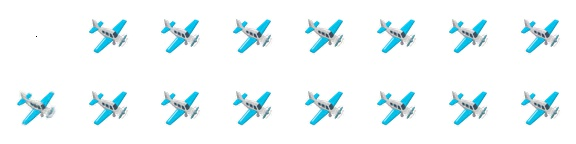

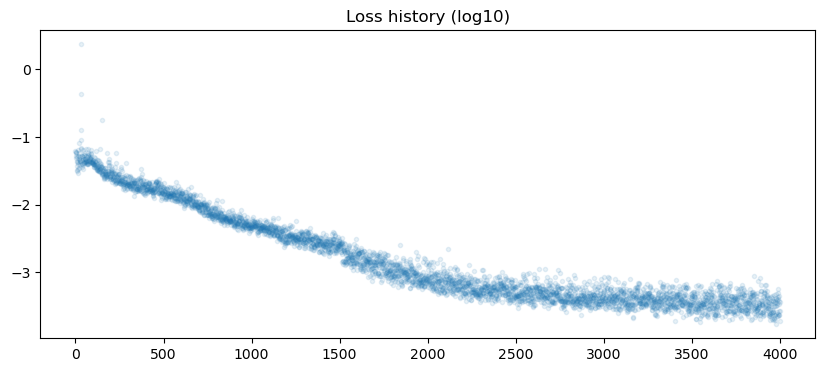

 step: 4001, log10(loss): -3.577CPU times: user 10min 27s, sys: 11.7 s, total: 10min 39s
Wall time: 8min 45s


In [470]:
%%time
# my model training instance (should be fixed)

my_ca = CAModel().to(device)
train_my_model = Train(my_ca.to(device), seed.to(device), pad_target.to(device))

loss_log_my_model = train_my_model.train(n_steps=4001)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 900/900 [00:00<00:00, 943.01it/s]


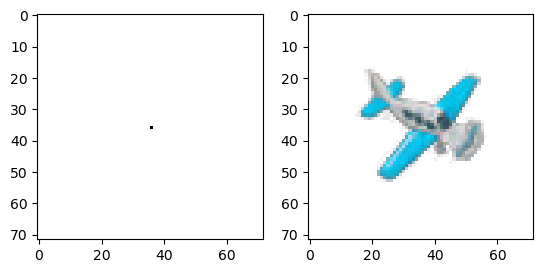

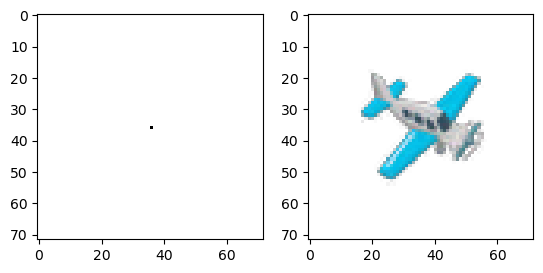

In [518]:
# My persistence implementation now works. Yay.
_ = simulate_model(my_ca, seed.unsqueeze(0).to(device), 90, device=device)
_ = simulate_model(my_ca, seed.unsqueeze(0).to(device), 900, device=device)

batch (before/after):


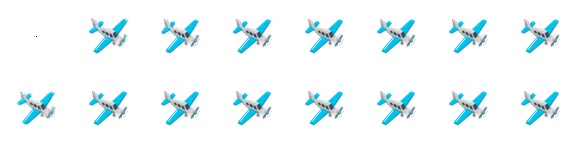

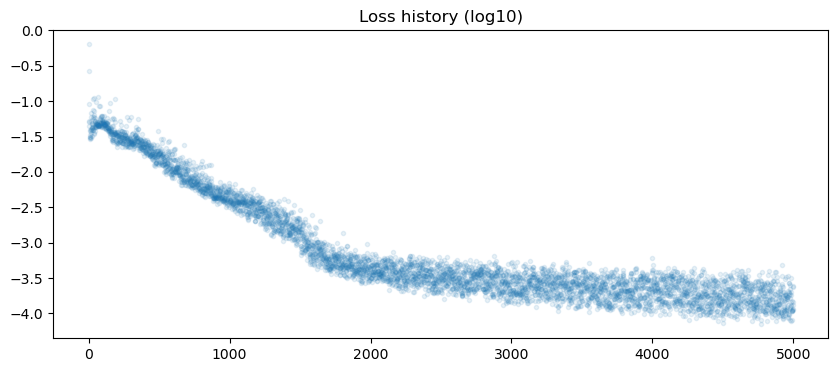

 step: 5001, log10(loss): -3.633CPU times: user 12min 26s, sys: 17.2 s, total: 12min 43s
Wall time: 10min 26s


In [171]:
%%time
# working run

ca = CA().to(device)
train = Train(ca.to(device), seed.to(device), pad_target.to(device))

loss_log = train.train(n_steps=5001)

batch (before/after):


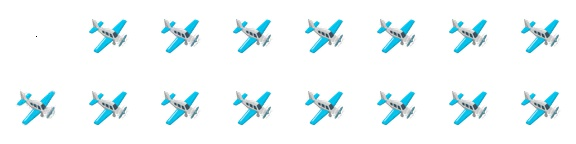

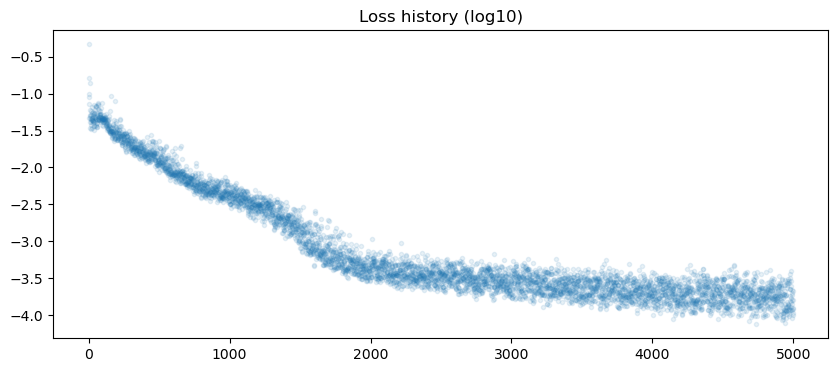

 step: 5001, log10(loss): -3.978CPU times: user 10min 54s, sys: 11.6 s, total: 11min 6s
Wall time: 8min 46s


In [174]:
%%time
# This is the good implementation 

ca = CA().to(device)
train = Train(ca.to(device), seed.to(device), pad_target.to(device))

loss_log = train.train(n_steps=5001)

batch (before/after):


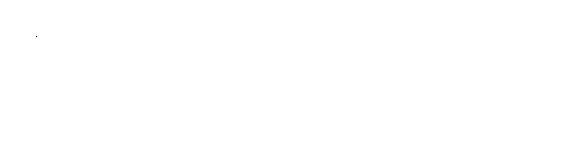

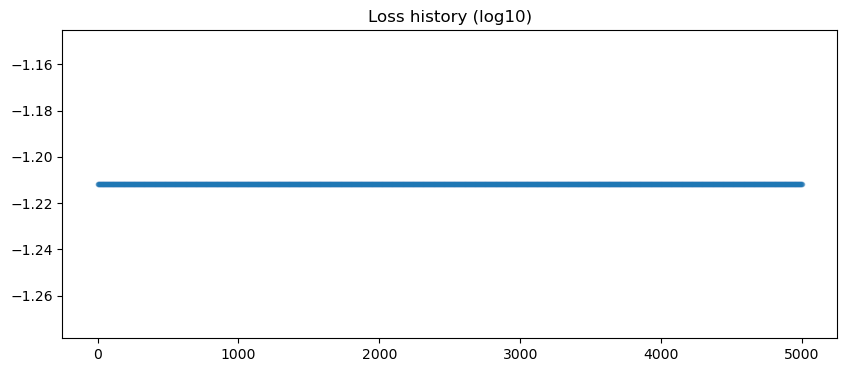

 step: 5001, log10(loss): -1.212CPU times: user 11min 4s, sys: 13.2 s, total: 11min 17s
Wall time: 8min 55s


In [173]:
%%time
# Sometimes the min NCA dies out

ca = CA().to(device)
train = Train(ca.to(device), seed.to(device), pad_target.to(device))

loss_log = train.train(n_steps=5001)

batch (before/after):


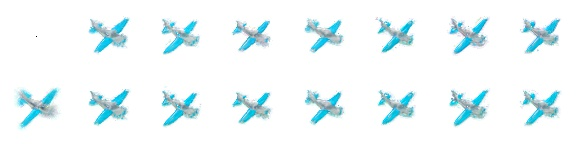

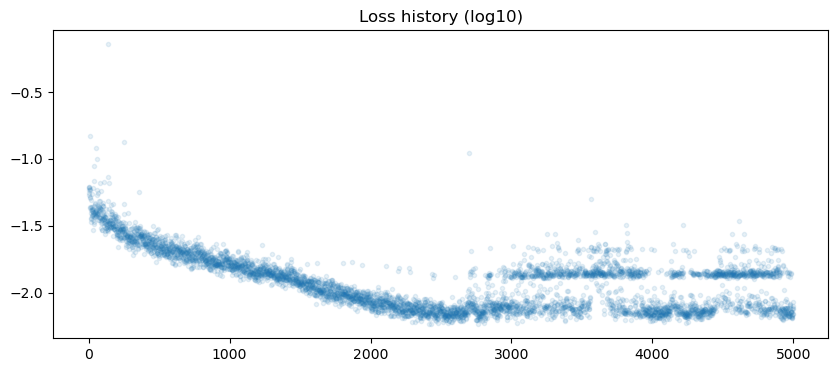

 step: 5001, log10(loss): -2.156CPU times: user 14min 16s, sys: 12.9 s, total: 14min 29s
Wall time: 12min 8s


In [172]:
%%time
# bad training run

my_ca = CAModel().to(device)
train_my_model = Train(my_ca.to(device), seed.to(device), pad_target.to(device))

loss_log_my_model = train_my_model.train(n_steps=5001)

batch (before/after):


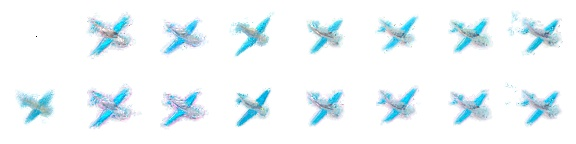

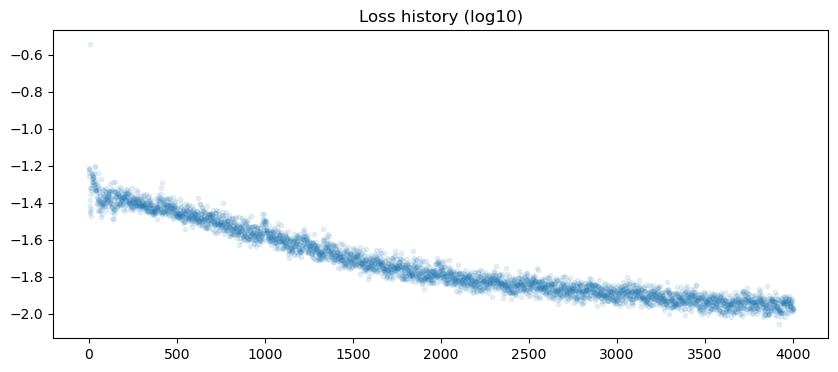

 step: 4001, log10(loss): -1.973CPU times: user 20min 32s, sys: 25 s, total: 20min 57s
Wall time: 22min 36s


In [33]:
%%time
# bad training run number x

ca = CAModel().to(device)
train = Train(ca, seed.to(device), pad_target.to(device))

loss_log = train.train(n_steps=5001)

batch (before/after):


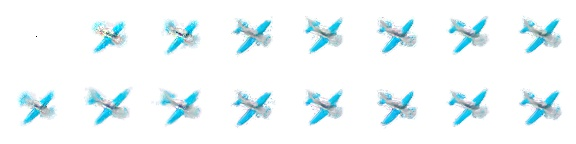

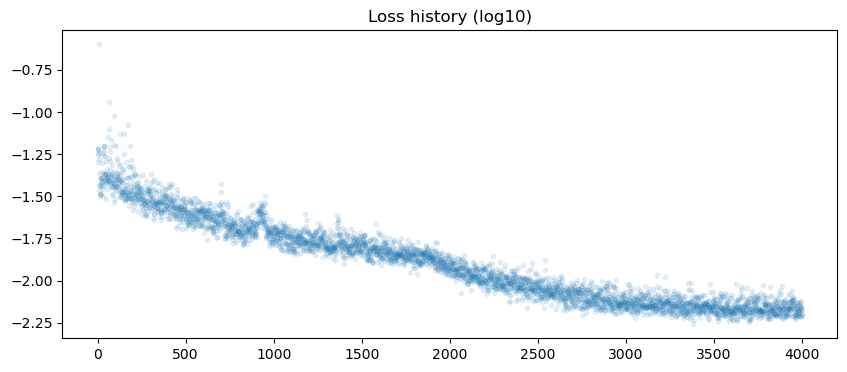

 step: 4001, log10(loss): -2.208CPU times: user 15min 57s, sys: 12.1 s, total: 16min 9s
Wall time: 15min 20s


In [19]:
%%time
# different versions of bad training runs (before fix)

ca = CAModel().to(device)
train = Train(ca, seed.to(device), pad_target.to(device))

loss_log = train.train(n_steps=4001)

In [152]:
save_ca_model(ca, "persistent_1")

Saved model persistent_1 to disk


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 678.04it/s]

batch (before/after):


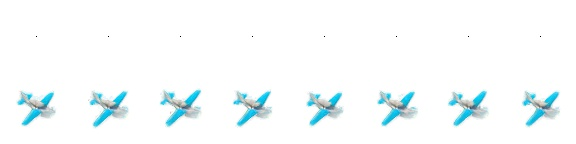

In [78]:
importlib.reload(sys.modules['original_utils'])
from original_utils import *
x = simulate_model(ca.to(device), x0.to(device), n_steps=195, device=device)

## Minimal Neural Cellular Automata (Alternative PyTorch Implementation To Mine)

Reference: https://greydanus.github.io/2022/05/24/studying-growth/

(1, 4, 72, 72) <class 'numpy.ndarray'>
(1, 72, 72, 4)


/tmp/ipykernel_3208623/4731981.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img.thumbnail((40,40), PIL.Image.ANTIALIAS)


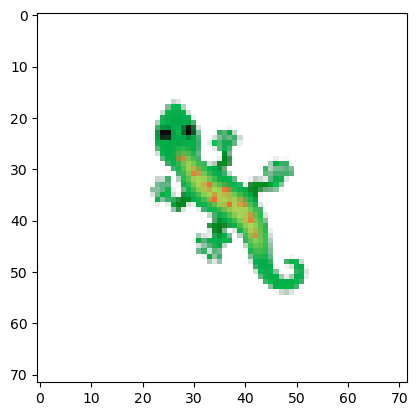

In [253]:
def get_dataset(k=16):
  r = requests.get('https://greydanus.github.io/files/lizard_1f98e.png')
  img = PIL.Image.open(io.BytesIO(r.content))  # get image: emoji_u1f98e (🦎)
  img.thumbnail((40,40), PIL.Image.ANTIALIAS)
  img = np.float32(img)/255.0                  # convert image to NumPy array
  img *= img[..., 3:]                          # premultiply RGB by alpha
  img = img.transpose(2,0,1)[None,...]         # axes are [N, C, H, W]
  return {'y': np.pad(img, ((0,0),(0,0),(k,k),(k,k)))}  # pad image

y = get_dataset()
test_y = y['y']
print(test_y.shape, type(test_y))
y_reshaped = np.transpose(test_y, (0, 2, 3, 1))
print(y_reshaped.shape)
assert y_reshaped.shape == (1, 72, 72, 4)
plt.imshow(y_reshaped[0, ...])

In [254]:
# Implement the Neural Cellular Automata as a PyTorch module
class CA(nn.Module): 
  def __init__(self, state_dim=16, hidden_dim=128):
    super(CA, self).__init__()
    self.state_dim = state_dim
    self.update = nn.Sequential(nn.Conv2d(state_dim, 3*state_dim, 3, padding=1, groups=state_dim, bias=False),  # perceive
                                nn.Conv2d(3*state_dim, hidden_dim, 1),  # process perceptual inputs
                                nn.ReLU(),                              # nonlinearity
                                nn.Conv2d(hidden_dim, state_dim, 1))    # output a residual update
    self.update[-1].weight.data *= 0  # initial residual updates should be close to zero
    
    # First conv layer will use fixed Sobel filters to perceive neighbors
    identity = np.outer([0, 1, 0], [0, 1, 0])       # identity filter
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0      # Sobel x filter
    kernel = np.stack([identity, dx, dx.T], axis=0) # stack (identity, dx, dy) filters
    kernel = np.tile(kernel, [state_dim,1,1])       # tile over channel dimension
    self.update[0].weight.data[...] = torch.Tensor(kernel)[:,None,:,:]
    self.update[0].weight.requires_grad = False
  
  def forward(self, x, num_steps):
    alive_mask = lambda alpha: nn.functional.max_pool2d(alpha, 3, stride=1, padding=1) > 0.1
    frames = []
    for i in range(num_steps):
      alive_mask_pre = alive_mask(alpha=x[:,3:4])
      update_mask = torch.rand(*x.shape, device=x.device) > 0.5  # run a state update 1/2 of time
      x = x + update_mask * self.update(x)                       # state update!
      x = x * alive_mask_pre * alive_mask(alpha=x[:,3:4])        # a cell is either living or dead
      frames.append(x.clone())
    return torch.stack(frames) # axes: [N, B, C, H, W] where N is # of steps


In [255]:
def normalize_grads(model):  # makes training more stable, especially early on
  for p in model.parameters():
      p.grad = p.grad / (p.grad.norm() + 1e-8) if p.grad is not None else p.grad

def train(model, pad_target, n_steps=1001):
  model = model.to(device)  # put the model on GPU
  optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
  scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1500], gamma=0.25)

  # target_rgba = torch.Tensor(pad_target['y']).to(device)  # put the target image on GPU
  target_rgba = torch.repeat_interleave(pad_target[None, ...], BATCH_SIZE, dim=0)
  target_rgba = pad_target[None, ...]
  target_rgba = target_rgba.permute(0, -1, 1, 2).contiguous()
                                            
  init_state = torch.zeros(BATCH_SIZE, CHANNEL_N, *target_rgba.shape[-2:]).to(device)


  init_state[...,init_state.shape[-2]//2,init_state.shape[-1]//2] = 1.  # initially, there is just one cell
  pool = init_state[:1].repeat(POOL_SIZE,1,1,1)
  
  loss_log = []

  for step in range(n_steps):

    if POOL_SIZE > 0:  # draw CAs from pool (if we have one)
      pool_ixs = np.random.randint(POOL_SIZE, size=[BATCH_SIZE])
      input_states = pool[pool_ixs]
    else:
      input_states = init_state

    states = model(input_states, np.random.randint(64, 96, dtype=np.int32))  # forward pass
    final_rgba = states[-1,:, :4]  # grab rgba channels of last frame

    # compute loss and run backward pass
    mses = (target_rgba.unsqueeze(0)-final_rgba).pow(2)
    batch_mses = mses.view(BATCH_SIZE,-1).mean(-1)
    loss = batch_mses.mean()
    loss.backward() ; normalize_grads(model)
    optimizer.step() ; optimizer.zero_grad() ; scheduler.step()

    # update the pool (if we have one)
    if POOL_SIZE > 0:
      final_states = states[-1].detach()
      final_states[batch_mses.argmax()] = init_state[:1]
      pool[pool_ixs] = final_states

    loss_log.append(loss.item())
    if step % 100 == 0:

      # clear_output()
      visualize_x0 = input_states[...].detach().cpu().permute(0, 2, 3, 1)
      visualize_x = states[-1, ...].detach().cpu().permute(0, 2, 3, 1)

      # Visualize batch
      visualize_batch(visualize_x0, visualize_x, step)

      # Plot loss
      plot_loss(loss_log)

    print('\r step: %d, log10(loss): %.3f'%(len(loss_log), np.log10(loss_log[-1])), end='')
        
  return loss_log

# Comparisons

Comparing individual components of CA model class implementation with the one found here:
https://greydanus.github.io/2022/05/24/studying-growth/

In [183]:
def reshape(tensor, channels_last=True):
    """Reshape input torch tensor to (B, H, W, C) if 
        channels_last is true, and to (B, C, H, W) otherwise
    """
    if channels_last:
        return tensor.permute(0, 2, 3, 1)
    else:
        return tensor.permute(0, -1, 1, 2)
    
# Unit tests
channels_last_tensor = torch.randn(8, 40, 40, 16)
channels_first_tensor = torch.randn(8, 16, 40, 40)
assert channels_last_tensor.shape == reshape(channels_first_tensor).shape
assert channels_first_tensor.shape == reshape(channels_last_tensor, channels_last=False).shape

In [184]:
# Define Model (my implementation)

class CAModel(nn.Module):
  def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
    super().__init__()
    self.channel_n = channel_n
    self.fire_rate = fire_rate

    conv1 = nn.Conv2d(in_channels=self.channel_n*3, out_channels=128, kernel_size=1)
    conv2 = nn.Conv2d(in_channels=128, out_channels=self.channel_n, kernel_size=1)
    
    # Apply "do-nothing" initial behavior
    # torch.nn.init.xavier_uniform_(conv1.weight) # default to how tensorflow initializes the weights
    torch.nn.init.zeros_(conv2.weight)
    torch.nn.init.zeros_(conv1.bias)
    torch.nn.init.zeros_(conv2.bias)

    self.dmodel = nn.Sequential(
        conv1,
        nn.ReLU(),
        conv2,
    )
    
  def perceive(self, x, angle=0.0):
    """Pytorch does convolutions differently. Reshape accordingly
      input is (batch, in_channels, H, W)
      kernel is (filter_height, filter_width, in_channels, channel_multiplier) in TF
      but should be (out_channels, in_channels / groups, H, W) in Torch"""
    identify = torch.as_tensor([0, 1, 0], dtype=torch.float32)
    identify = torch.outer(identify, identify)
    dx = torch.as_tensor(np.outer([1, 2, 1], [-1, 0, 1]) / 8.0, dtype=torch.float32) # Sobel filter
    dy = dx.T
    c, s = torch.cos(torch.tensor(angle)), torch.sin(torch.tensor(angle))
    stacked_filters = torch.stack((identify, c*dx-s*dy, s*dx+c*dy)).to(device)
    kernel = torch.repeat_interleave(stacked_filters, self.channel_n, dim=0).view(self.channel_n*3, 1, 3, 3)
    y = F.conv2d(x, kernel, padding='same', groups=self.channel_n)
    return y

  def forward(self, x, fire_rate=None, angle=0.0, step_size=1.0):
    x = torch.permute(x, (0, 3, 1, 2)) # make it shape [batch_size, in_channels, H, W]
    pre_life_mask = get_living_mask(x)

    y = self.perceive(x, angle) # y should be on device
    dx = self.dmodel(y)*step_size
    if fire_rate is None:
      fire_rate = self.fire_rate
    update_mask = torch.rand(x[:, :1, :, :].shape, device=device, dtype=torch.float32) <= fire_rate
    x = x + dx * update_mask

    post_life_mask = get_living_mask(x)
    life_mask = pre_life_mask & post_life_mask
    result = x * life_mask
    return torch.permute(result, (0, 2, 3, 1)) # send it back [batch_size, H, W, in_channels]

CAModel().dmodel

Sequential(
  (0): Conv2d(48, 128, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
)

In [509]:
## Take apart the perception layers and inspect

# Make some data first
B, C, H, W = 2, 3, 4, 4
inp = torch.randn(B, C, H, W)

def my_perceive(tensor, angle=0.0):
    tensor = tensor.to(device)
    identify = torch.as_tensor([0, 1, 0], dtype=torch.float32)
    identify = torch.outer(identify, identify)
    dx = torch.as_tensor(np.outer([1, 2, 1], [-1, 0, 1]) / 8.0, dtype=torch.float32)
    dy = dx.T    
    c, s = torch.cos(torch.tensor(angle)), torch.sin(torch.tensor(angle))
    stacked_filters = torch.stack((identify, c*dx-s*dy, s*dx+c*dy)).to(device)  
    print(f"stacked_filters shape: {stacked_filters.shape}")
    # kernel = torch.repeat_interleave(
    #     stacked_filters, C, dim=0).view(C*3, 1, 3, 3)
    kernel = stacked_filters.tile((C, 1, 1))
    print(f'kernel shape: {kernel.shape}')
    # print('kernels:')
    # print(kernel)
    y = F.conv2d(tensor, kernel[:, None, :, :], padding='same', groups=C)
    # print(f'y shape: {y.shape}')
    return y

def min_perceive(tensor):
    tensor = tensor.to(device)
    identity = np.outer([0, 1, 0], [0, 1, 0])
    dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0
    kernel = np.stack([identity, dx, dx.T], axis=0)
    kernel = np.tile(kernel, [C, 1, 1])
    
    # Construct perception convolution operation
    update = nn.Conv2d(C, 3*C, 3, padding=1, groups=C, bias=False, device=device)
    update.weight.data[...] = torch.tensor(kernel, device=device)[:, None, :, :]
    update.weight.requires_grad = False
    
    # print(f"other kernels:")
    # print(kernel)
    
    # Pass through perception
    y = update(tensor)
    y = torch.round(y, decimals=4)
    return y   
    

In [471]:
# Create individual tensor for inspection

t = torch.tensor([
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9],
], dtype=torch.float32).unsqueeze(0).repeat_interleave(3, dim=0)
t[1, ...] *= 2
t[2, ...] *= 3
print(t.shape, t.dim(), t.sum())
print(t)

torch.Size([3, 3, 3]) 3 tensor(270.)
tensor([[[ 1.,  2.,  3.],
         [ 4.,  5.,  6.],
         [ 7.,  8.,  9.]],

        [[ 2.,  4.,  6.],
         [ 8., 10., 12.],
         [14., 16., 18.]],

        [[ 3.,  6.,  9.],
         [12., 15., 18.],
         [21., 24., 27.]]])


In [502]:
# Play with numpy.tile

tester = np.tile(t, (3, 1, 1))
print(tester.shape)

(9, 3, 3)


In [503]:
# Set kernel and perception according to his implementation

tiled = np.tile(t, (C, 1, 1))
print(tiled.shape)
conv2d = nn.Conv2d(C, 3*C, 3, padding=1, groups=C, bias=False)
conv2d.weight.data[:] = torch.tensor(tiled)[:, None, ...]
conv2d.weight.requires_grad = False
kernels = conv2d.weight.data
print(kernels.shape)
kernels
min_out = conv2d(inp)
print(inp.shape, min_out.shape)
inp[0, ...].shape

(9, 3, 3)
torch.Size([9, 1, 3, 3])
torch.Size([2, 3, 4, 4]) torch.Size([2, 9, 4, 4])


torch.Size([3, 4, 4])

In [451]:
# Tile in torch

torch_tiled = torch.tile(t, (3, 1, 1))
print(torch_tiled.shape)
my_out = F.conv2d(inp, torch_tiled[:, None, ...], padding='same', groups=C)
my_out.shape

torch.Size([9, 3, 3])


torch.Size([2, 9, 4, 4])

In [504]:
# Compare with torch's repeat_interleave.
# Similar to tile, which is what was throwing me off initially.

torched = torch.repeat_interleave(t, torch.tensor([3,3,3]), dim=0)
print(torched.shape)
# torched

torch.Size([9, 3, 3])


In [505]:
# Create the stacked kernel (with the three filters - identity, sobel X/Y

tensor = inp.clone()
tensor = tensor.to(device)
identity = np.outer([0, 1, 0], [0, 1, 0])
dx = np.outer([1, 2, 1], [-1, 0, 1]) / 8.0
kernel = np.stack([identity, dx, dx.T], axis=0)
print(kernel.shape)
print(kernel)

kernel = np.tile(kernel, [C, 1, 1])
# print('...............')
# print(kernel.shape)
# print(kernel)

(3, 3, 3)
[[[ 0.     0.     0.   ]
  [ 0.     1.     0.   ]
  [ 0.     0.     0.   ]]

 [[-0.125  0.     0.125]
  [-0.25   0.     0.25 ]
  [-0.125  0.     0.125]]

 [[-0.125 -0.25  -0.125]
  [ 0.     0.     0.   ]
  [ 0.125  0.25   0.125]]]


In [507]:
# Stack them using Torch

stacked_filters = torch.stack((torch.tensor(identity), 
                               torch.tensor(dx), 
                               torch.tensor(dx).T), dim=0)
print(stacked_filters.shape)
print(stacked_filters)

torch.Size([3, 3, 3])
tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  1.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[-0.1250,  0.0000,  0.1250],
         [-0.2500,  0.0000,  0.2500],
         [-0.1250,  0.0000,  0.1250]],

        [[-0.1250, -0.2500, -0.1250],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.1250,  0.2500,  0.1250]]], dtype=torch.float64)


In [511]:
# Compare output of perception layer (both mine and his)

print(inp.shape)
my_out_tensor = my_perceive(inp)
print(my_out_tensor.shape)

min_out_tensor = min_perceive(inp)

assert my_out_tensor.shape == min_out_tensor.shape

torch.Size([2, 3, 4, 4])
stacked_filters shape: torch.Size([3, 3, 3])
kernel shape: torch.Size([9, 3, 3])
torch.Size([2, 9, 4, 4])


In [514]:
torch.allclose(my_out_tensor, min_out_tensor, 1e-1) # beware the tolerance

True

In [515]:
# Manually inspect tensor elements

print("My Out Tensor:")
print(my_out_tensor[:, 2:4, ...])

print("Min Out Tensor:")
print(min_out_tensor[:, 2:4, ...])

My Out Tensor:
tensor([[[[-0.0039, -0.2447, -0.2930, -0.3348],
          [-0.6958, -0.8502, -0.3639,  0.2255],
          [-0.0812,  0.5371,  0.8365,  0.7758],
          [ 0.2325,  0.4984,  0.4527,  0.0028]],

         [[-0.2151,  1.7112, -0.1530,  0.8928],
          [ 0.3948, -0.1473, -0.4842, -0.0613],
          [ 1.4864, -0.0633,  0.6129, -1.2279],
          [ 0.1279, -1.1010, -0.8749,  0.4805]]],


        [[[ 0.0187,  0.0159,  0.0500,  0.2643],
          [-0.1625,  0.3653,  0.6304,  0.2840],
          [-0.5399, -0.4702, -0.4025, -0.4269],
          [ 0.2533, -0.0264, -0.3146, -0.3408]],

         [[-0.9460, -0.6706, -0.0276, -0.1047],
          [ 0.4314, -0.7726,  0.1829, -0.4418],
          [-0.1421, -0.0711, -0.3448, -0.4719],
          [ 0.1663,  0.7757,  0.9959,  1.4983]]]], device='cuda:1')
Min Out Tensor:
tensor([[[[-0.0039, -0.2447, -0.2930, -0.3348],
          [-0.6958, -0.8502, -0.3639,  0.2255],
          [-0.0812,  0.5371,  0.8365,  0.7758],
          [ 0.2325,  0.4984, 

In conclusion the problem I was having was that I was not convolving all the perception matrices with the channels correctly. The same matrix was getting repeated 16 times (because of torch's repeat_interleave, which repeats each element some number of times). There may be a way to do this with repeat_interleave but I can't think of it right now, so I moved to using torch's tile which is similar to numpy's.

I learned a lot about tensors though, including differences between torch.Tensor, torch.tensor, torch.as_tensor, and torch.from_numpy. Tldr, use torch.tensor, as torch.Tensor is a class constructor (I believe that's how it's called?), whereas torch.tensor is an actual factory function used to create an object instance.

The last two functions share memory with the source array, so I guess they are basically just wrappers? In actuality the last three are all factory functions (need to look into this more).

Finally, learned about contiguous memory in tensors. Apparently torch.view requires the tensor memory to be contiguous, which you can do with torch.Tensor.contiguous(). Again, not sure I fully understand this but it is good to keep in mind.

SIR,

May 5, 2023